# K means analysis at sentence level



## Initialization/Function Definitions

In [117]:
# Imports
import embeddings
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import math
import numpy as np
import re
import string
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import faiss

from collections import Counter
from nltk.corpus import brown
from process_sentences import get_tokenized_sentences, get_sentence_embedding
from utils import get_index

In [118]:
# Functions for doing k-means

# Define functions for running kmeans and calculating cluster radii
def run_km(X, n_clusters=3, n_trials=10, n_iterations=1000):
  km = KMeans(n_clusters=n_clusters, n_init=n_trials, max_iter=n_iterations)
  return km.fit(X)

# Returns Euclidean distance between centroid and farthest point in that cluster
# Considers only "percent" of points where "percent" is between 0 and 1
def get_cluster_radii(X, KM, metric="euclidean", percent=1):
  centers = KM.cluster_centers_
  
  distances = [[] for x in range(0, len(centers))]
  for emb, label in zip(X, KM.labels_):
    if metric == 'euclidean':
      dis = np.linalg.norm(emb - centers[label])
    distances[label].append(dis)

  radii = {k: 0 for k in range(0, len(centers))}
  sizes = {k: 0 for k in range(0, len(centers))}
  for label, dis in enumerate(distances):
    dis.sort()
    if len(dis) > 20:
        target_len = math.floor(percent*len(dis)) - 1
        radii[label] = dis[target_len]
    else:
        radii[label] = dis[-1]
    
    sizes[label] = len(dis)
  return radii, sizes

# Function to plot fit based on number of clusters using inertia
def plot_fit(X, metric, min_val=1, max_val=25):

  # calculate distortion for a range of number of cluster
  scores = []
  for i in range(min_val, max_val+1):
      km = run_km(X, n_clusters=i)
      if metric == 'inertia':
        scores.append(km.inertia_)
      elif metric == 'silhouette':
        scores.append(metrics.silhouette_score(X, km.labels_, metric='euclidean') if i > 1 else -1)
      elif metric == 'calinski-harabasz':
        scores.append(metrics.calinski_harabasz_score(X, km.labels_) if i > 1 else 0)
      elif metric == 'davies-bouldin':
        scores.append(metrics.davies_bouldin_score(X, km.labels_)if i > 1 else 1)

  # plot
  plt.plot(range(min_val, max_val+1), scores, 'o')
  plt.xlabel('Number of clusters')
  plt.ylabel(metric.title())
  plt.show()


In [125]:
# Functions to measure how close results are to Zipf distribution
# For log-log plot, slope should be close to -1

# Get slope of vals
def fit_slope(vals):
  x = list(range(1, len(vals) + 1))
  y = vals
  logx = np.log(x)
  logy = np.log(y)
  coeffs = np.polyfit(logx, logy, deg=1)
  poly = np.poly1d(coeffs)
  print("Best Fit Slope is", poly[1])
  return poly

# Make log-log plot of values
def plot_log_log(vals, dataset, comparison='count'):
  font_size = 20
  rank = list(range(1, len(vals) + 1))
  vals.sort(reverse=True)
  a, b = fit_slope(vals)
  x = list(range(1, len(vals) + 1))
  y_line = [np.log(x_val)*a + b for x_val in x]
  fig, _ = plt.subplots()
  plt.scatter(np.log(rank), np.log(vals))
  plt.plot(np.log(x), y_line, color="darkorange")
           # is %f"%round(a, 4))
  plt.xlabel("Log of Rank", fontsize=font_size)
  if comparison == 'count':
      plt.ylabel("Log of Number of Points", fontsize=font_size)
#       plt.legend(['Line of Best Fit %f'%a, 'Number of Points vs Rank'])
  else:
    plt.ylabel("Log of Radius")
#     plt.legend(['Line of Best Fit', 'Radius vs Rank'])
# create a list with two empty handles (or more if needed)
  handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)]

# create the corresponding number of labels (= the text you want to display)
  labels = []
  labels.append("Best Fit Slope = {0:.5g}".format(a))

# create the legend, supressing the blank space of the empty line symbol and the
# padding between symbol and label by setting handlelenght and handletextpad
  plt.legend(handles, labels, loc='best',
            fancybox=True, framealpha=0.7, 
            handlelength=0, handletextpad=0, fontsize=font_size-3)
    
  plt.xticks(fontsize=font_size)
  plt.yticks(fontsize=font_size)
  plt.show()
  fig.savefig(f"{dataset}_count_rank.pdf", bbox_inches='tight')
  return a

# Do final run and plot fit
def check_zipfs(X, k_opt, dataset, km=None, include_weighted=True, radius=False, radius_size=0.95):
  if km is None:
      km = run_km(X, n_clusters=k_opt)

  # Gather information about each cluster
  labels = list(km.labels_)
  cluster_dict = {k:{'unique': 0, 'total': 0, 'words': []} for k in range(0, k_opt)}
  if include_weighted:
    for word, label in zip(words, labels):
      cluster_dict[label]['unique'] += 1
      cluster_dict[label]['total'] += word_counter[word]
      cluster_dict[label]['words'].append(word)
  else:
    for label in labels:
      cluster_dict[label]['unique'] += 1

  # print(cluster_dict)

  # Print total count
  # print(sum([x['total'] for x in cluster_dict.values()]))

  # Order cluster information
  # unweighted_clusters is the raw number of unique points in each cluster
  # weighted_clusters is the number of words in the source text captured by the cluster
  unweighted_clusters = sorted([x['unique'] for x in cluster_dict.values()], reverse=True)
  weighted_clusters = None

  a = plot_log_log(unweighted_clusters, dataset)
  if include_weighted:
    weighted_clusters = sorted([x['total'] for x in cluster_dict.values()], reverse=True)
    plot_log_log(weighted_clusters)
  return a
  
  if radius:
    rad, count = get_cluster_radii(X, km, percent=radius_size)
    c_vals = list(count.values())
    r_vals = list(rad.values())
    plt.scatter(c_vals, r_vals)
    plt.xlabel("Count")
    plt.ylabel("Radius")
    z = np.polyfit(c_vals, r_vals, 1)
    print("Trend Slope is", z[0])
    p = np.poly1d(z)
    plt.plot(c_vals,p(c_vals))
    plt.show()
    radii = sorted(rad.values(), reverse=True)
    _ = plot_log_log(radii[3:], comparison="radius")
  
  return unweighted_clusters, weighted_clusters, cluster_dict, a

def get_extremes(i, n=5):
    mean = means[i]
    points = [(ind_2_sen[j], np.linalg.norm(sen_2_emb[ind_2_sen[j]] - mean)) for j, l in enumerate(km.labels_) if l == i]
    ordered = [j[0] for j in sorted(points, key=lambda x: x[1])]
    print('\n'.join(ordered[:n]))
    print()
    print('\n'.join(ordered[-n:]))

## RACE Corpus

In [176]:
# Initialize embeddings
embedder = embeddings.FastTextEmbedding()

sens = get_tokenized_sentences('RACE_corpus')
sen_2_emb = {' '.join(x): get_sentence_embedding(x, embedder) for x in sens if get_sentence_embedding(x, embedder) is not None}

In [177]:
print(len(sen_2_emb))
print(type(sen_2_emb))

492921
<class 'dict'>


In [178]:
ind_2_sen = {k:v for k, v in enumerate(sen_2_emb.keys())}
index = get_index(sen_2_emb)
X = np.asarray(list(sen_2_emb.values())).astype('float32')

In [185]:
n = 95
km = run_km(X, n_clusters=n)
means = km.cluster_centers_
sizes = [len([x for x in km.labels_ if x == i]) for i in range(n)]
print(sizes)

[747, 5736, 7165, 2613, 12003, 15182, 2148, 12374, 1110, 1888, 1693, 7792, 9878, 2312, 5691, 12695, 4031, 8921, 2877, 12760, 1436, 10568, 3889, 5134, 5019, 5713, 4647, 5930, 7771, 4801, 7290, 5234, 5672, 2980, 4151, 1940, 945, 1795, 5827, 8601, 5909, 5507, 7230, 3988, 13327, 2057, 865, 3119, 6588, 2306, 3432, 9548, 6343, 4571, 3733, 459, 7127, 9805, 2897, 7414, 7806, 576, 834, 5277, 4632, 1736, 5931, 6107, 4029, 9094, 1563, 11083, 1841, 4760, 832, 4375, 4071, 6698, 3021, 1357, 9682, 2894, 5729, 2957, 4930, 3417, 7966, 4986, 523, 2027, 10466, 4468, 1799, 9287, 983]


Best Fit Slope is -0.7229669700956958


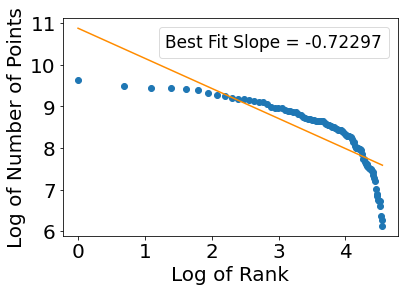

In [186]:


a = check_zipfs(X, n, "race", km=km, include_weighted=False, radius=False, radius_size=0.95)



In [112]:
# for i in range(n):
get_extremes(18)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Bring him to the lamp ! ” Down , and up , and head foremost on the steps of the building ; now , on his knees ; now , on his feet ; now , on his back ; dragged , and struck at , and stifled by the bunches of grass and straw that were thrust into his face by hundreds of hands ; torn , bruised , panting , bleeding , yet always entreating and beseeching for mercy ; now full of vehement agony of action , with a small clear space about him as the people drew one another back that they might see ; now , a log of dead wood drawn through a forest of legs ; he was hauled to the nearest street corner where one of the fatal lamps swung , and there Madame Defarge let him go -- as a cat might have done to a mouse -- and silently and composedly looked at him while they made ready , and while he besought her : the women passionately screeching at him all the time , and the men sternly calling out to have him killed with grass in his mouth .
While his learned friend , Mr. Stryver , massing his papers 

Best Fit Slope is -1.1137104718583348


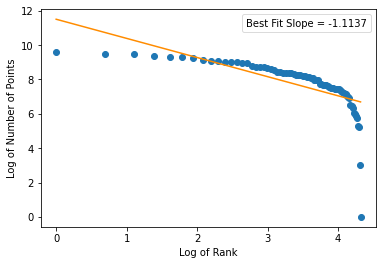

Trend Slope is -5.1009520234537936e-05


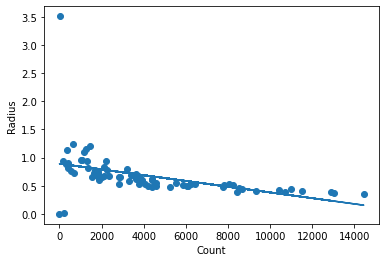

Best Fit Slope is -0.6265734954014099


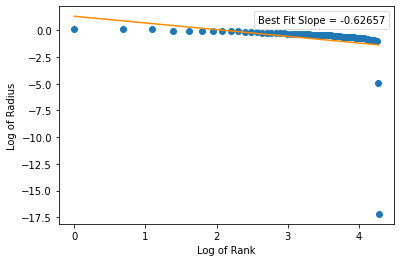

Best Fit Slope is -1.0345594929380075


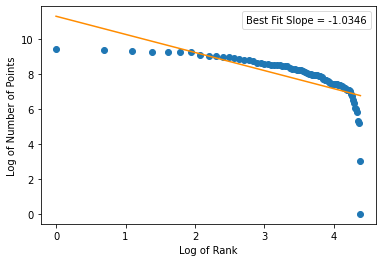

Trend Slope is -5.588223360893574e-05


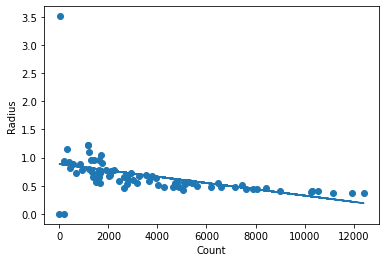

Best Fit Slope is -0.7425128422681985


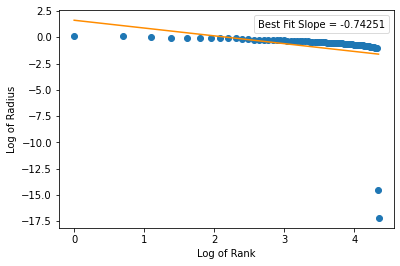

Best Fit Slope is -1.0996030738070173


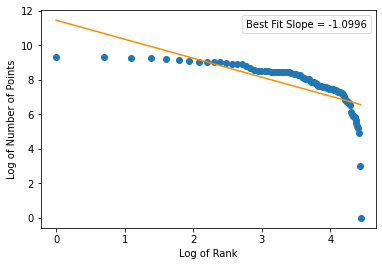

Trend Slope is -5.6011994611540876e-05


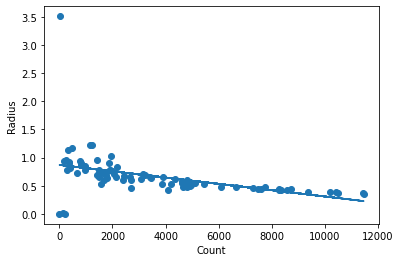

Best Fit Slope is -0.7673667222222492


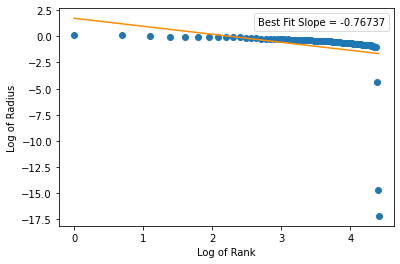

Best Fit Slope is -1.005609740201175


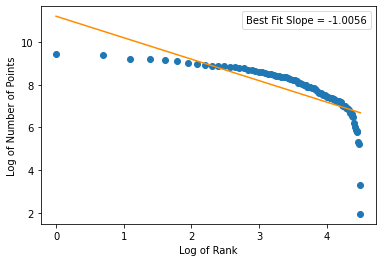

Trend Slope is -7.13676703621031e-05


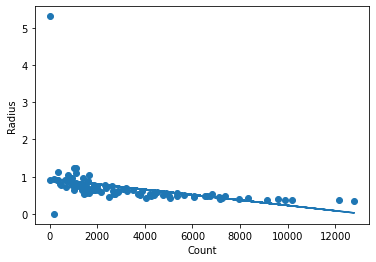

Best Fit Slope is -0.47553569737242946


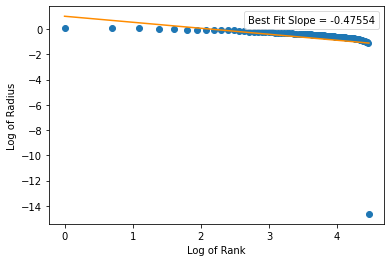

Best Fit Slope is -0.9880644615465812


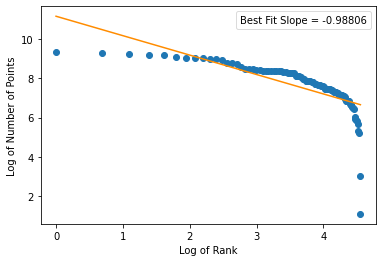

Trend Slope is -6.67718551033457e-05


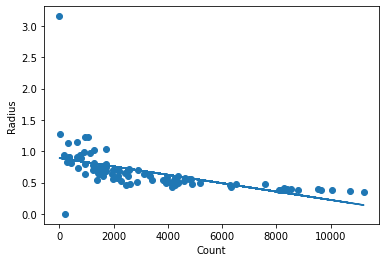

Best Fit Slope is -0.47373587416537016


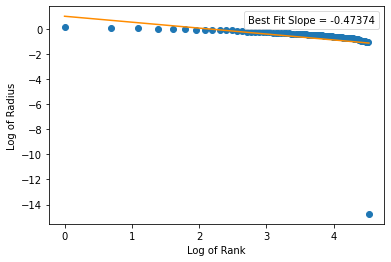

Best Fit Slope is -1.0116586353638228


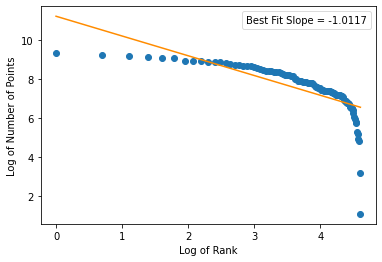

Trend Slope is -6.632521517467662e-05


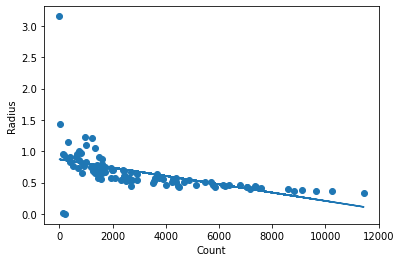

Best Fit Slope is -0.501146751382326


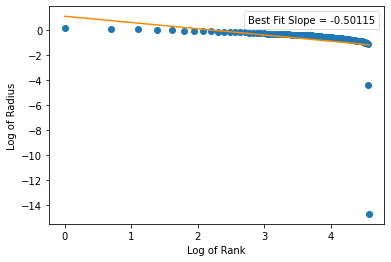

Best Fit Slope is -0.9412109928275456


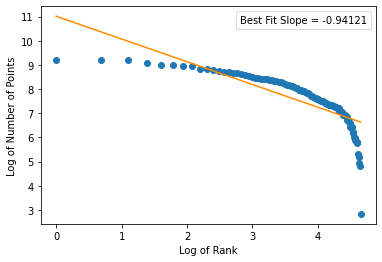

Trend Slope is -8.895938166088417e-05


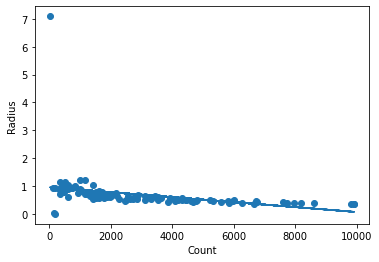

Best Fit Slope is -0.48236166369961986


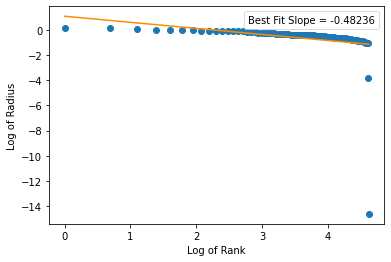

Best Fit Slope is -0.9858897989369337


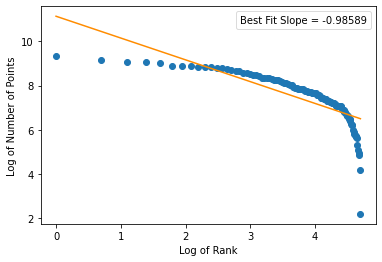

Trend Slope is -7.810127256406426e-05


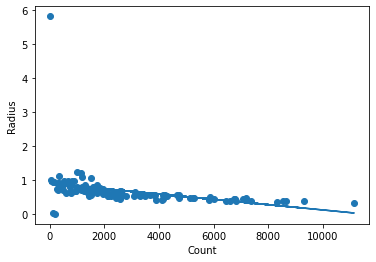

Best Fit Slope is -0.45953245604649917


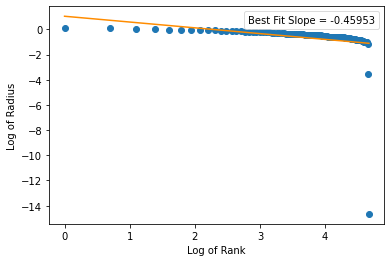

Best Fit Slope is -0.9959033828217907


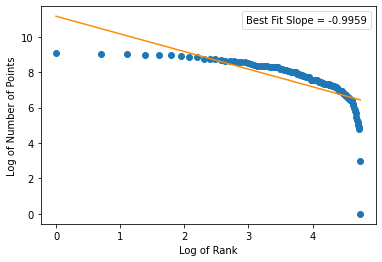

Trend Slope is -7.197975876610863e-05


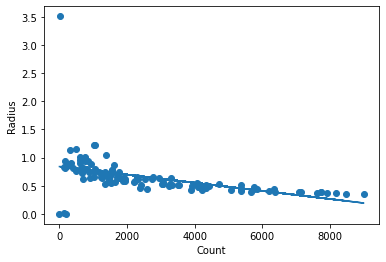

Best Fit Slope is -0.6207473486899161


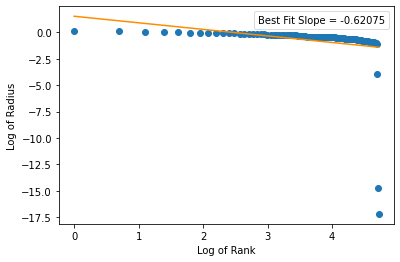

Best Fit Slope is -0.974199361680648


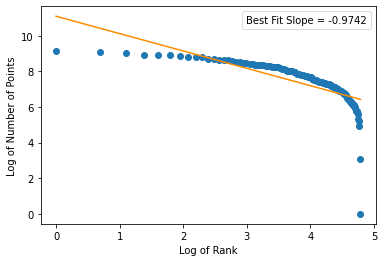

Trend Slope is -6.630818991480453e-05


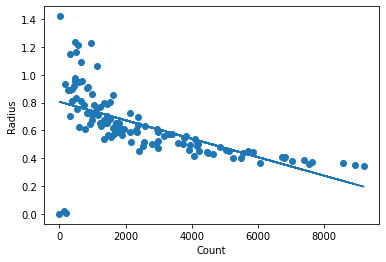

Best Fit Slope is -0.52016029430961


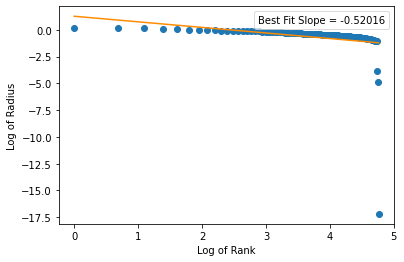

In [54]:
vals = []
for n in range(75, 125, 5):
    km = run_km(X, n_clusters=n)
    means = km.cluster_centers_
    sizes = [len([x for x in km.labels_ if x == i]) for i in range(n)]
    _, _, _, a = check_zipfs(X, n, km=km, include_weighted=False, radius=True, radius_size=0.95)
    vals.append(a)

Best Fit Slope is -1.0061660921350457


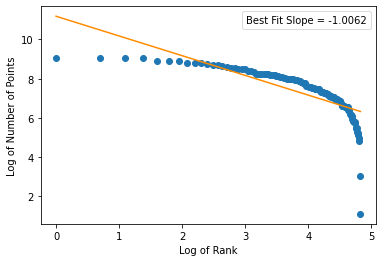

Trend Slope is -7.662121474073112e-05


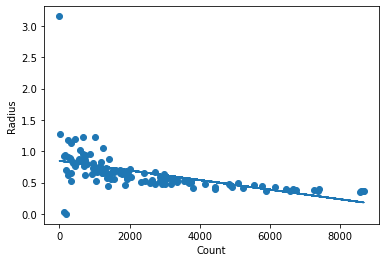

Best Fit Slope is -0.4499461018375838


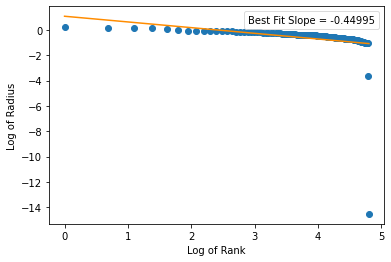

In [56]:
vals_2 = []
for n in range(125, 130, 5):
    km = run_km(X, n_clusters=n)
    means = km.cluster_centers_
    sizes = [len([x for x in km.labels_ if x == i]) for i in range(n)]
    _, _, _, a = check_zipfs(X, n, km=km, include_weighted=False, radius=True, radius_size=0.95)
    vals_2.append(a)

In [57]:
print(vals_2)

[-1.0061660921350457]


In [58]:
print(vals + vals_2)

[-1.1137104718583348, -1.0345594929380075, -1.0996030738070173, -1.005609740201175, -0.9880644615465812, -1.0116586353638228, -0.9412109928275456, -0.9858897989369337, -0.9959033828217907, -0.974199361680648, -1.0061660921350457]
